In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter,medfilt
from scipy import interpolate
from datetime import datetime, date, time, timedelta
from numpy import diff
import math
import quaternion
import polars as pl
from tqdm import tqdm

In [5]:
_pth = r'D:\CMC\DeepVision\recorded_data\validation\skimu3_30_4_random_1m_0\imu01.csv'

In [9]:
timeoffset = 0.0
_imu_df = pl.read_csv(_pth)

dt = _imu_df["mils"].diff().mean()/1000
dt = 0.011
filter_size = 101
filter_order = 9
_mean_gx = _imu_df["gx"][:filter_size ].mean()
_mean_gy = _imu_df["gy"][:filter_size ].mean()
_mean_gz = _imu_df["gz"][:filter_size ].mean()
_mean_ax = _imu_df["ax"][:filter_size ].mean()
_mean_ay = _imu_df["ay"][:filter_size ].mean()
_mean_az = _imu_df["az"][:filter_size ].mean()

# subtracting mean from gyro
_imu_df = _imu_df.with_columns([
    (pl.col("gx") - _mean_gx).alias("gx"),
    (pl.col("gy") - _mean_gy).alias("gy"),
    (pl.col("gz") - _mean_gz).alias("gz"),
])

# subtracting mean from accel
_imu_df = _imu_df.with_columns([
    (pl.col("ax") - _mean_ax).alias("ax"),
    (pl.col("ay") - _mean_ay).alias("ay"),
    (pl.col("az") - _mean_az).alias("az"),
])

# apply savgol filter
_imu_df = _imu_df.with_columns([
                        pl.col("ax").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode(),
                        pl.col("ay").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode(),
                        pl.col("az").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode()
                    ])

_imu_df = _imu_df.with_columns([
                (pl.col("gx").cumsum()*dt * 9.81).alias("ang_x"),
                (pl.col("gy").cumsum()*dt * 9.81).alias("ang_y"),
                (pl.col("gz").cumsum()*dt * 9.81).alias("ang_z"),
            ])

_imu_df = _imu_df.with_columns(pl.col("sys_time").str.to_datetime().alias("time"))
_imu_df = _imu_df.with_columns(pl.col("time").map(lambda x: x + timedelta(seconds=timeoffset)).alias("time"))

#change string to float
_imu_df = _imu_df.with_columns(pl.col("mz\r").str.replace("\r","").cast(pl.Float64).alias("mz"))

In [10]:
pl_df = _imu_df

In [11]:
omegaXprime = []
omegaYprime = []
omegaZprime = []
Gamma = 0.174
for idx in tqdm(range(len(pl_df))): 
    row1_sensor = [1, 0, 0]
    row2_sensor = [0, np.cos(Gamma), np.sin(Gamma)]
    row3_sensor = [0, -np.sin(Gamma), np.cos(Gamma)]
    _SC = np.array([row1_sensor, row2_sensor, row3_sensor]).reshape(3,3)
    # _Ws = [df["CorrectGyroX"].loc[idx], df["CorrectGyroY"].loc[idx], df["CorrectGyroz"].loc[idx]]
    _Ws = np.array([pl_df['ang_x'][idx], pl_df['ang_y'][idx], pl_df['ang_z'][idx]]).reshape(1,3)
    Ws = np.reshape(_Ws,(3,1))
    _omegaChassis = np.dot(_SC, Ws)
    omegaXprime = np.append( omegaXprime,_omegaChassis[0][0])
    omegaYprime = np.append( omegaYprime,_omegaChassis[1][0])
    omegaZprime = np.append( omegaZprime,_omegaChassis[2][0])


  0%|          | 0/9357 [00:00<?, ?it/s]

100%|██████████| 9357/9357 [00:00<00:00, 53034.56it/s]


In [12]:
# series0 = pl.Series('Zeroes',np.zeros(len(pl_df)))

acc_data = pl_df[['ax', 'ay', 'az']].to_numpy()
# gyro_data = pl_df[['CorrectGyroX', 'CorrectGyroY', 'CorrectGyroz']].to_numpy()
# gyro_data = np.hstack((omegaXprime.reshape((len(pl_df),1)),omegaYprime.reshape((len(pl_df),1)),omegaZprime.reshape((len(pl_df),1))))
gyro_data = pl_df[['ang_x', 'ang_y', 'ang_z']].to_numpy()
norm_gyro = np.linalg.norm(gyro_data, axis= 1)
Zeroes = np.zeros(len(pl_df)).reshape(len(pl_df),1)
q_acc = np.hstack((Zeroes, acc_data))
q_ref = [0, 1, 0, 0]
x = np.array([1 ,0 ,0]).reshape(3,1)


In [14]:
del_t = 0.011

In [15]:
axis_gyro = []
del_theta = []
q_del_gyro = []
for idx in tqdm(range(len(pl_df))):
    if np.linalg.norm(gyro_data) == 0:
        _axis_gyro = np.array([0.0, 0.0, 0.0, 0.0]).reshape(1,4)
    else:    
        _axis_gyro = np.array([gyro_data[idx][0]/norm_gyro[idx],gyro_data[idx][1]/norm_gyro[idx],gyro_data[idx][2]/norm_gyro[idx]]).reshape(1,3)
    _del_theta = del_t*norm_gyro[idx]
    axis_gyro = np.append(axis_gyro, _axis_gyro)
    q_del0 = np.cos(_del_theta/2)
    q_del1 = axis_gyro[0]*np.sin(_del_theta/2)
    q_del2 = axis_gyro[1]*np.sin(_del_theta/2)
    q_del3 = axis_gyro[2]*np.sin(_del_theta/2)
    _q_del = [q_del0,q_del1,q_del2,q_del3]
    q_del_gyro = np.append(q_del_gyro, _q_del)

axis_gyro = axis_gyro.reshape(len(pl_df),3)
q_del_gyro = q_del_gyro.reshape(len(pl_df),4)

100%|██████████| 9357/9357 [00:00<00:00, 52679.76it/s]


In [16]:
q_acc = quaternion.as_quat_array(q_acc)
q_del_gyro = quaternion.as_quat_array(q_del_gyro)

In [26]:
orient = []
tilt_quat = []
sint = []
S = []
T = []
alpha = 0.9
q_gyro_i = q_del_gyro[0]
for idx in range(len(pl_df)):
    # gyro_t_norm_sq = q_gyro_i.w*q_gyro_i.w + q_gyro_i.x*q_gyro_i.x + q_gyro_i.y*q_gyro_i.y + q_gyro_i.z*q_gyro_i.z
    q_gyro_i_inv = q_gyro_i.conjugate()
    q_acc_prime  = q_gyro_i*q_acc[idx]*q_gyro_i_inv
    acc_prime = np.array([q_acc_prime.x, q_acc_prime.y, q_acc_prime.z]).reshape(1,3)
    acc_init = np.array([q_acc[0].x, q_acc[0].y, q_acc[0].z]).reshape(1,3)
    v_tilt = np.cross(acc_prime, acc_init)
    norm_v_tilt = np.linalg.norm(v_tilt)
    axis_q_t = v_tilt/norm_v_tilt
    
    s = np.dot(acc_prime, acc_init.reshape(3,1))/(norm_v_tilt*np.linalg.norm(acc_init))
     
    
    theta_c =  2*math.atan2(norm_v_tilt,s)
    theta_c =  np.arccos(s)
    T = np.append(T, theta_c)
    S = np.append(S,s)
   
    q_t0 = np.cos(alpha*theta_c/2)
    q_t1 = axis_q_t[0][0]*np.sin(alpha*theta_c/2)
    q_t2 = axis_q_t[0][1]*np.sin(alpha*theta_c/2)
    q_t3 = axis_q_t[0][2]*np.sin(alpha*theta_c/2)
    q_t = np.quaternion(q_t0,q_t1,q_t2,q_t3)
    q_t_inv = q_t.conjugate()
    q_gyro_i = q_t*q_gyro_i
    tilt_quat = np.append(tilt_quat, q_gyro_i)
    # _orient  = 2*np.arccos(q_gyro_i.w)
    norm_x = np.linalg.norm(np.array([q_gyro_i.x, q_gyro_i.y, q_gyro_i.z]).reshape(1,3))
    _orient = 2*np.arccos(q_gyro_i.w)
    orient = np.append(orient, _orient)


C:\Users\Pintu\AppData\Local\Temp\ipykernel_10380\1142361350.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  theta_c =  2*math.atan2(norm_v_tilt,s)
C:\Users\Pintu\AppData\Local\Temp\ipykernel_10380\1142361350.py:22: RuntimeWarning: invalid value encountered in arccos
  theta_c =  np.arccos(s)
C:\Users\Pintu\AppData\Local\Temp\ipykernel_10380\1142361350.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  q_t = np.quaternion(q_t0,q_t1,q_t2,q_t3)


In [28]:
print(axis_q_t[0][2])

nan


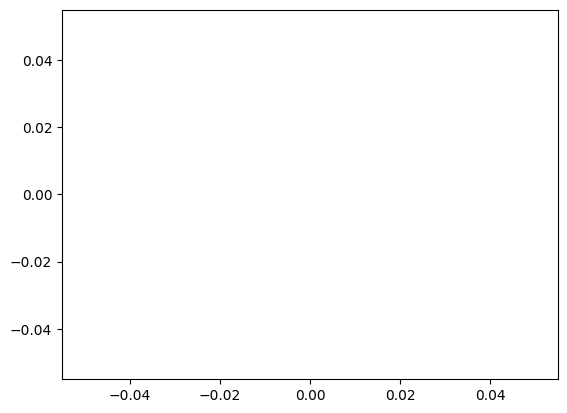

In [29]:
# plt.plot(S)
# plt.ylim(-1,1)
plt.plot(np.rad2deg(orient))
# plt.plot(np.rad2deg(theta_sensor))
# plt.plot(T)

In [45]:
x = np.array([q_gyro_i.x, q_gyro_i.y, q_gyro_i.z]).reshape(1,3)